In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

import numpy as np
import torch
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.transforms import ToTensor

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False
        
def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  ToTensor()(meshgrid)
    else:
        assert False
        
    return net_input

# Data

In [3]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

subject_data = np.nan_to_num(np.concatenate(subject_data))

### Endmember Extraction

#### NFINDR

In [16]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(subject_data.reshape(subject_data.shape[0]*subject_data.shape[1], subject_data.shape[2], -1), 4, maxit=1024, normalize=False,ATGP_init=True))

#### VCA

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import scipy.linalg as splin

class VCA(TransformerMixin, BaseEstimator):
    def __init__(self, n_endmembers:int, snr_input=0):
        super(VCA, self).__init__()
        self.n_endmembers = n_endmembers
        self.snr_input = snr_input

    def fit(self, X, y=None):
        '''
            Parameters
            ----------
                X : array, shape (n_samples, n_features)
                    Matrix with dimensions N (number of pixels) x L (number of  channels). Each pixel is a
                    linear mixture of R endmembers signatures Y = M x s, where s = gamma x alfa.
                    Gamma is a illumination perturbation factor and alfa are the abundance
                    fractions of each endmember

                y : any, default=None
                    Ignored. This parameter exists only for compatibility with
                    sklearn.pipeline.Pipeline.

            Returns
            -------
            self : object
                Returns the instance itself.
        '''
        X_ = X.T
        L, N = X_.shape   # L number of bands (channels), N number of pixels
        R = self.n_endmembers

        if (self.n_endmembers<0 or self.n_endmembers>L):
            raise ValueError('Number of endmemembers parameter must be integer between 1 and L')

        if self.snr_input == 0:
            y_m = np.mean(X_,axis=1,keepdims=True)
            Y_o = X_ - y_m           # data with zero-mean
            Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
            x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

            SNR = self._estimate_snr(X_,y_m,x_p)
        else:
            SNR = self.snr_input

        SNR_th = 15 + 10*np.log10(R)

        if SNR < SNR_th:
            # ... Select proj. to R-1
            d = R-1
            if self.snr_input==0: # it means that the projection is already computed
                Ud = Ud[:,:d]
            else:
                y_m = np.mean(X_,axis=1,keepdims=True)
                Y_o = X_ - y_m  # data with zero-mean 
                
                Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
                x_p =  np.dot(Ud.T,Y_o)                 # project the zeros-mean data onto p-subspace
                        
            Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                        
            x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
            c = np.amax(np.sum(x**2,axis=0))**0.5
            y = np.vstack(( x, c*np.ones((1,N)) ))

        else: 
            # ... Select the projective proj.
                    
            d = R
            Ud  = splin.svd(np.dot(X_,X_.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                        
            x_p = np.dot(Ud.T,X_)
            Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                        
            x =  np.dot(Ud.T,X_)
            u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
            y =  x / (np.dot(u.T,x) + 1e-16)

        #############################################
        # VCA algorithm
        #############################################

        indice = np.zeros((R),dtype=int)
        A = np.zeros((R,R))
        A[-1,0] = 1

        for i in range(R):
            w = np.random.rand(R,1);   
            f = w - np.dot(A,np.dot(splin.pinv(A),w))
            f = f / splin.norm(f)
            
            v = np.dot(f.T,y)

            indice[i] = np.argmax(np.absolute(v))
            A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

        Ae = Yp[:,indice]

        self.Ae_ = Ae
        self.idx_ = indice
        self.Xp_ = Yp
        
        return self

    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self)
        return self.Xp_[:,self.idx_]

    def _estimate_snr(self, X, X_mean_0, reduced_x) -> float:
        L, N = X.shape          # L number of bands (channels), N number of pixels
        p, N = reduced_x.shape  # p number of endmembers (reduced dimension)
        
        P_y     = np.sum(X**2)/float(N)
        P_x     = np.sum(reduced_x**2)/float(N) + np.sum(X_mean_0**2)
        return 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )

In [9]:
eea = VCA(4)
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
U = eea.fit_transform(data)
U = torch.tensor(U.T)

In [10]:
U.shape

torch.Size([4, 116])

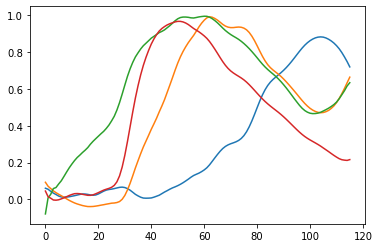

In [11]:
from matplotlib import pyplot as plt 
plt.plot(U.T)
plt.show()

In [12]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.NEAREST),
])

In [13]:
from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class TestDataset(Dataset):
    def __init__(self, data, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(TestDataset, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

train_set = TestDataset(subject_data, transform)

In [14]:
from torch.utils.data import DataLoader

loader = DataLoader(train_set, batch_size=32, shuffle=False)
X_tensor = next(iter(loader))

In [15]:
# X_tensor = torch.unsqueeze(transform(X_std), dim=0)
# X_tensor = torch.unsqueeze(transform(subject_data), dim=0)
noisy_input = []
for i in range(X_tensor.shape[0]):
    noisy_input.append(get_noise(X_tensor.shape[1], 'noise', X_tensor.shape[2:], noise_type='u'))

noisy_input = torch.cat(noisy_input, axis=0)

# U_tensor = torch.unsqueeze(U_std.T, dim=0).float()
U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

Z shape: torch.Size([5, 116, 64, 64])
HyperCube shape: torch.Size([5, 116, 64, 64])
Endmember shape: torch.Size([1, 116, 4])


In [16]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

in_channels = [n_bands, 256]
out_channels = [32, 128]
skip_channels = [4, 8]

model = UnDIP(in_channels, out_channels, skip_channels, n_endmembers)

In [17]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

batch_size = X_tensor.shape[0]
n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')
show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
for i in range(4):
    target_imgs = torch.unsqueeze(X_tensor[i, show_band_idx], dim=1)
    img_grid = make_grid(target_imgs)
    tb_writer.add_image('Target/{}'.format(i), img_grid, 0)


noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((output.shape[0], n_bands, w, h))

    for i in range(4):
        rest_imgs = torch.unsqueeze(restoration[i, show_band_idx], dim=1)
        img_grid = make_grid(rest_imgs)
        tb_writer.add_image('Output/{}'.format(i), img_grid, epoch)

        abundance_imgs = torch.unsqueeze(output[i], dim=1)
        img_grid = make_grid(abundance_imgs)
        tb_writer.add_image('Abundance/{}'.format(i), img_grid, epoch)

    batch_loss = criterion(restoration, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

100%|██████████| 10000/10000 [28:06<00:00,  5.93epoch/s, tls=0.0254]


In [ ]:
from scipy.io import loadmat
mat = loadmat(os.path.join(config.DERMA_DATASET_DIR, 'train/P32_C1000.mat'))
X = mat['preProcessedImage'].astype(np.float64)

tiny_X = X.reshape((X.shape[0]*X.shape[1],X.shape[2]))

In [ ]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(X, 6, maxit=1024, normalize=False,ATGP_init=True))

In [ ]:
from HySpecLab.transform import StandarizedTransform
std_transform = StandarizedTransform()

tiny_X_std = std_transform.fit_transform(tiny_X)
X_std = tiny_X_std.reshape(X.shape)
U_std = std_transform.transform(U)

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(U.T)
ax[0].set_title('Original Endmember')
ax[1].plot(U_std.T)
ax[1].set_title('Standarized Endmember')
plt.show()

In [ ]:
# plt.plot(tiny_X[[100, 120, 200, 500]].T)
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(tiny_X[[100, 120, 200, 500]].T)
ax[0].set_title('Original Data')
ax[1].plot(tiny_X_std[[100, 120, 200, 500]].T)
ax[1].set_title('Standarized Data')
plt.show()

In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.NEAREST),
])

In [ ]:
# X_tensor = torch.unsqueeze(transform(X_std), dim=0)
X_tensor = torch.unsqueeze(transform(X), dim=0)
noisy_input = get_noise(X_tensor.shape[1], 'noise', X_tensor.shape[2:], noise_type='u')

# U_tensor = torch.unsqueeze(U_std.T, dim=0).float()
U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

In [ ]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

in_channels = [n_bands, 256]
out_channels = [32, 128]
skip_channels = [4, 8]

model = UnDIP(in_channels, out_channels, skip_channels, n_endmembers)

# Train

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')
show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
target_imgs = torch.unsqueeze(X_tensor[0, show_band_idx], dim=1)
img_grid = make_grid(target_imgs)
tb_writer.add_image('Target', img_grid, 0)

noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((1, n_bands, w, h))

    rest_imgs = torch.unsqueeze(restoration[0, show_band_idx], dim=1)
    img_grid = make_grid(rest_imgs)
    tb_writer.add_image('Output', img_grid, epoch)

    abundance_imgs = torch.unsqueeze(output[0], dim=1)
    img_grid = make_grid(abundance_imgs)
    tb_writer.add_image('Abundance', img_grid, epoch)

    batch_loss = criterion(restoration, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

In [37]:
A = model(noisy_input)

In [38]:
torch.save(A, 'Abundance.pt')

In [39]:
A = torch.load('Abundance.pt')

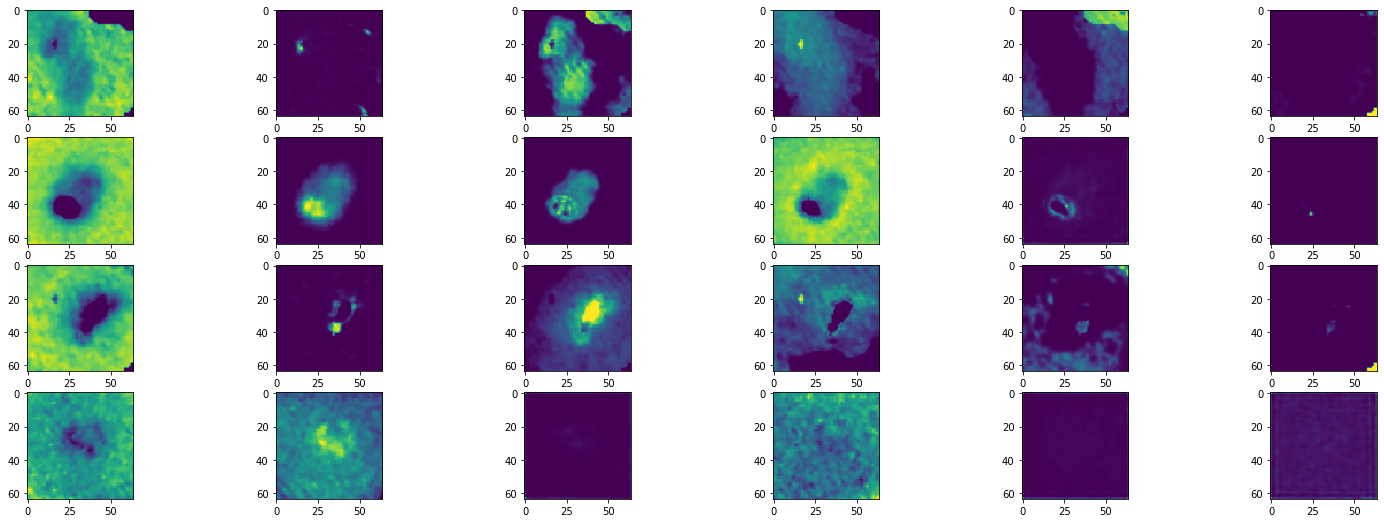

In [44]:
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

A = A.cpu().detach()
fig, ax = plt.subplots(4,6, figsize=(26,9))
for i in range(len(A[0])):
    if i >= 4:
        break
    
    for j in range(len(A[1])):
        ax[i, j].imshow(A[i,j])

    

In [ ]:
noisy_input.min()

# Testing